In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
vacc_url = 'https://opendata.arcgis.com/datasets/722c84e36ad040c6a75fdec6b768b13f_0.csv'
df = pd.read_csv(vacc_url, parse_dates=['ADMIN_DATE'])
df.to_csv('../data/raw/vaccines.csv', index=False)

In [3]:
df = df.dropna(thresh=5).copy()

In [4]:
bad_dates = {}

for group_name, df_group in df[df['ADMIN_DATE']<'15 DEC 2020'].groupby('MVX'):
    bad_dates[group_name] = len(df_group)

df = df[df['ADMIN_DATE']>='15 DEC 2020'].copy()

In [5]:
bad_dates

{'MOD': 10, 'PFR': 17}

In [6]:
df = df[df['DOSE_NUM']<2].copy()

In [7]:
df['ADMIN_DATE'] = pd.to_datetime(df['ADMIN_DATE']).dt.date

In [8]:
df_vacc = pd.pivot_table(df, values='DOSE_NUM', index='ADMIN_DATE', columns='MVX', aggfunc='sum')

In [9]:
df_vacc = df_vacc.fillna(0)

In [10]:
cols = df_vacc.columns
df_vacc['total'] = df_vacc[cols].sum(axis=1)

In [36]:
df_vacc.to_csv('../data/parsed/vaccines.csv', index=True)

In [11]:
from fbprophet import Prophet

In [12]:
m_pfr = Prophet(growth='logistic')
m_tot = Prophet(growth='logistic')

In [13]:
df_pfr = df_vacc.reset_index()[['ADMIN_DATE', 'PFR']]
df_pfr.columns = ['ds', 'y']
df_pfr['cap']=10E3
df_pfr['floor']=0

df_tot = df_vacc.reset_index()[['ADMIN_DATE', 'total']]
df_tot.columns = ['ds', 'y']
df_tot['cap']=10E3
df_tot['floor']=0

In [14]:
m_pfr.fit(df_pfr)
m_tot.fit(df_tot)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
future_pfr = m_pfr.make_future_dataframe(periods=60)
future_pfr['cap'] =10E3
future_pfr['floor'] = 0
future_pfr.tail()

future_tot = m_tot.make_future_dataframe(periods=60)
future_tot['cap'] =10E3
future_tot['floor'] = 0
future_tot.tail()

,ds,cap,floor
128,2021-04-22,10000.0,0
129,2021-04-23,10000.0,0
130,2021-04-24,10000.0,0
131,2021-04-25,10000.0,0
132,2021-04-26,10000.0,0


In [18]:
forecast_pfr = m_pfr.predict(future_pfr)
forecast_pfr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecast_tot = m_tot.predict(future_tot)
forecast_tot[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
128,2021-04-22,4036.813011,2548.183889,5596.032453
129,2021-04-23,4111.373981,2599.534294,5656.052595
130,2021-04-24,3026.741800,1429.538454,4425.860982
131,2021-04-25,1712.103257,169.717580,3268.283236
132,2021-04-26,2961.111388,1472.199554,4552.935457


Text(0.5, 33.0, '')

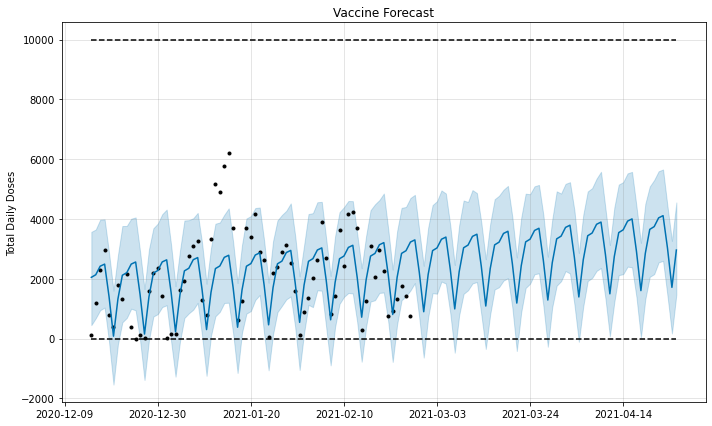

In [20]:
fig1 = m_tot.plot(forecast_tot)
plt.title('Vaccine Forecast')
plt.ylabel('Total Daily Doses')
plt.xlabel('')

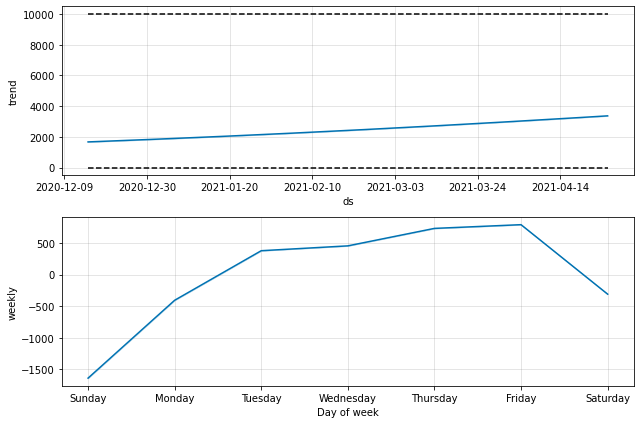

In [21]:
fig2 = m_tot.plot_components(forecast_tot)

In [23]:
from pmdarima import auto_arima


In [26]:
df1 = df_vacc.reset_index()[['ADMIN_DATE', 'total']]
df1 = df1.set_index('ADMIN_DATE')

In [29]:
model = auto_arima(df1, seasonal=False,m=3)

C:\Users\crock\AppData\Local\Continuum\miniconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (3) set for non-seasonal fit. Setting to 0



In [30]:
forecasts = model.predict(60)

In [35]:
model

ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True)

In [33]:
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

NameError: name 'y' is not defined